In [4]:
import json
import pandas as pd
from itertools import islice
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from scipy.stats import skellam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import validation_curve
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
import statsmodels.api as sm
import pymc3 as pm

In [5]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Part One 

### Hypothesis

The number of goal in the football games follows Poisson distribution

## The Poisson distribution

For ***discrete random variables***, the Poisson distribution models **unbounded counts**:

$$X = \{0,1,2,3,\ldots \}$$

$$Y = \{\ldots,-2,-1,0,1,2,\ldots\}$$

Its **probability *mass* function**: 

$$Pr(X=x) = f(x\;|\; \lambda)$$

![Discrete variable](http://upload.wikimedia.org/wikipedia/commons/1/16/Poisson_pmf.svg)

<div style="font-size: 120%;">  
$$Pr(X=x)=\frac{e^{-\lambda}\lambda^x}{x!}$$
</div>

* $X=\{0,1,2,\ldots\}$
* $\lambda > 0$

One useful property of the Poisson distribution is that its **expectation** (or first moment) as well as its **standard deviation** (or second moment) are equal to its *sole* parameter, i.e.:

$$E(X) = \text{Var}(X) = \lambda$$

# Dataset Discription
1. European Cup Dataset
2. World Cup Qualifiers Dataset
3. 1872-2022 Football Match Dataset
4. World Cup Dataset
5. European competition Dataset (multi-features)
    - Multi-feature: inclding detailed information (exp: the total number of corners, red cards, crosses, etc.)

In [6]:
def parse_2022():
    filename = './data/archive/2022.worldcup.quolification.output.jl'
    with open(filename) as f:
        data = pd.read_json(f.read(), lines=True)
    return data
data_2022 = parse_2022()
data_2022.rename(columns = {'team0':'home_team', 'team1':'away_team', 'score0': 'home_score', 'score1': 'away_score'}, inplace = True)
# area_and_stage = data_2022['area'].str.split(',', expand=True)
print(data_2022)

def parse_2002_to_2018():
    filename = './data/archive/2002-2018.worldcup.quolification.output.jl'
    with open(filename) as f:
        data = pd.read_json(f.read(), lines=True)
    return data

data_before = parse_2002_to_2018()
data_before.rename(columns = {'team0':'home_team', 'team1':'away_team', 'score0': 'home_score', 'score1': 'away_score'}, inplace = True)
print(data_before)


     year               area                  date   home_team    away_team  \
0    2022  UEFA, Group Stage    November 16, 2021    Gibraltar       Latvia   
1    2022     AFC, Round Two    September 5, 2019     Thailand      Vietnam   
2    2022   CAF, First Round   September 10, 2019     Eswatini     Djibouti   
3    2022  UEFA, Group Stage       March 27, 2021   Montenegro    Gibraltar   
4    2022           CONMEBOL     October 10, 2021    Venezuela      Ecuador   
..    ...                ...                   ...         ...          ...   
719  2022  UEFA, Group Stage    November 16, 2021      Finland       France   
720  2022  UEFA, Group Stage    September 4, 2021     Slovakia      Croatia   
721  2022     AFC, Round Two     October 10, 2019      IR Iran     Cambodia   
722  2022  UEFA, Group Stage    September 5, 2021      Albania      Hungary   
723  2022   AFC, Round Three     October 12, 2021      IR Iran  South Korea   

     home_score  away_score                   place

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [away_lambda]
>Metropolis: [home_lambda]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 6 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


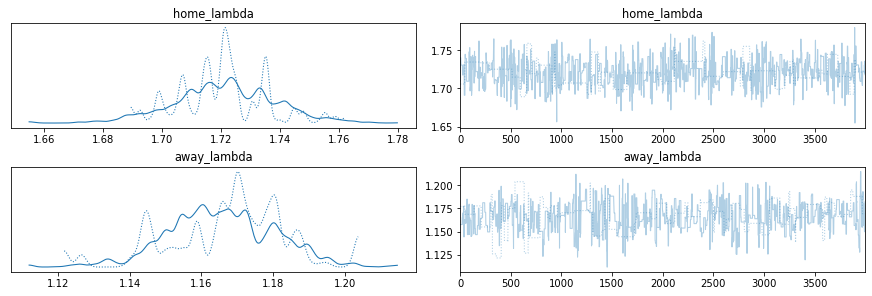

In [7]:
qua_world_cup = pd.concat([data_2022[['home_score', 'away_score']], data_before[['home_score', 'away_score']]])
with pm.Model() as model:
    home_alpha = 1. / qua_world_cup.home_score.mean()
    away_alpha = 1. / qua_world_cup.away_score.mean()
    home_lambda = pm.Exponential("home_lambda", home_alpha)
    away_lambda = pm.Exponential("away_lambda", away_alpha)
    home_points = pm.Poisson('home_points', mu=home_lambda, observed=qua_world_cup.home_score)
    away_points = pm.Poisson('away_points', mu=away_lambda, observed=qua_world_cup.away_score)
    step = pm.Metropolis()
    trace = pm.sample(4000, tune=1000, step=step, cores = 1)
    pm.traceplot(trace)

lambda_home_samples = trace['home_lambda']
lambda_away_samples = trace['away_lambda']

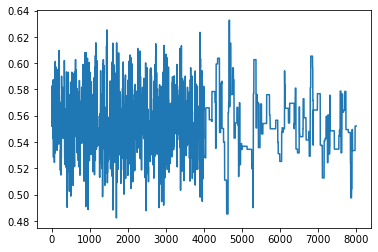

In [8]:
plt.plot(lambda_home_samples - lambda_away_samples)

In [9]:
print( 'lambda_home_samples mean:', lambda_home_samples.mean() )
print( 'lambda_away_samples mean:', lambda_away_samples.mean() )

lambda_home_samples mean: 1.7208940405628126
lambda_away_samples mean: 1.1664304316242506


In [10]:
def parse_eufa(file_path="data/data.txt"):
    data = list()
    with open(file_path, mode='r', encoding='utf-8') as f:
        skip_start_line = 3
        for line in islice(f, skip_start_line, None):
            fields = line.strip().split('\t')
            data.append(fields)

    return data


def parse_arc_data(result_file_path="data/archive/results.csv", shootout_file_path="data/archive/shootouts.csv"):
    data = list()

    with open(result_file_path, mode='r', encoding='utf-8') as f:
        skip_start_line = 39701
        for line in islice(f, skip_start_line, None):
            fields = line.strip().split(',')

            # Add winner
            if fields[3] > fields[4]:
                fields.append(fields[1])
            elif fields[3] < fields[4]:
                fields.append(fields[2])
            else:
                fields.append("None")

            data.append(fields)

    with open(shootout_file_path, mode='r', encoding='utf-8') as f:
        skip_start_line = 403
        for line in islice(f, skip_start_line, None):
            date, ctry1, ctry2, winner = line.strip().split(',')

            for i in range(0, len(data)):
                if data[i][-1] == "None" and date == data[i][0]:
                    if (ctry1 == data[i][1] and ctry2 == data[i][2]) or (ctry1 == data[i][2] and ctry2 == data[i][1]):
                            data[i][-1] = winner
                    else:
                        continue

    return data


In [11]:
eufa_record = parse_eufa()

eufa_record_field_name = ['Date', 'Location', 'Country1', 'Country2', 'Score', 'Winner']
eufa_df = pd.DataFrame(eufa_record, columns =eufa_record_field_name)
print(eufa_df)

          Date     Location         Country1         Country2    Score  \
0   06/11/2021        Italy           Turkey            Italy      0:3   
1   06/12/2021   Azerbaijan            Wales      Switzerland      1:1   
2   06/12/2021      Denmark          Denmark          Finland      0:1   
3   06/12/2021       Russia          Belgium           Russia      3:0   
4   06/13/2021      England          England          Croatia      1:0   
5   06/13/2021      Romania          Austria  North Macedonia      3:1   
6   06/13/2021  Netherlands      Netherlands          Ukraine      3:2   
7   06/14/2021     Scotland         Scotland          Czechia      0:2   
8   06/14/2021       Russia           Poland         Slovakia      1:2   
9   06/14/2021        Spain            Spain           Sweden      0:0   
10  06/15/2021      Hungary          Hungary         Portugal      0:3   
11  06/15/2021      Germany           France          Germany      1:0   
12  06/16/2021       Russia          F

In [12]:
acr_record = parse_arc_data()

acr_record_field_name = ['date', 'home_team', 'away_team', 'home_score', 'away_score', 'tournament', 'city', 'country', 'neutral', 'winner']

acr_df = pd.DataFrame(acr_record, columns =acr_record_field_name)
acr_df['home_score'] = acr_df['home_score'].astype(int)
acr_df['away_score'] = acr_df['away_score'].astype(int)
print(acr_df)

            date        home_team             away_team  home_score  \
0     2018-01-02             Iraq  United Arab Emirates           0   
1     2018-01-02             Oman               Bahrain           1   
2     2018-01-05             Oman  United Arab Emirates           0   
3     2018-01-07          Estonia                Sweden           1   
4     2018-01-11          Denmark                Sweden           0   
...          ...              ...                   ...         ...   
3716  2022-03-30           Mexico           El Salvador           2   
3717  2022-03-30       Costa Rica         United States           2   
3718  2022-03-30           Panama                Canada           1   
3719  2022-03-30          Jamaica              Honduras           2   
3720  2022-03-30  Solomon Islands           New Zealand           0   

      away_score                    tournament         city  \
0              0                      Gulf Cup  Kuwait City   
1              0     

In [13]:
score_upperbound = 10
print(acr_df[acr_df['home_score'] > score_upperbound])
print(acr_df[acr_df['away_score'] > score_upperbound])

            date            home_team                 away_team  home_score  \
523   2018-09-08                 Cuba  Turks and Caicos Islands          11   
557   2018-09-10                Haiti              Sint Maarten          13   
641   2018-10-12              Bermuda              Sint Maarten          12   
1426  2019-07-15      Solomon Islands            American Samoa          13   
1433  2019-07-18        New Caledonia                    Tuvalu          11   
1712  2019-10-10                 Iran                  Cambodia          14   
1862  2019-11-10  Trinidad and Tobago                  Anguilla          15   
2532  2021-03-30                Japan                  Mongolia          14   
2652  2021-06-05               Panama                  Anguilla          13   

      away_score                             tournament            city  \
523            0  CONCACAF Nations League qualification          Havana   
557            0  CONCACAF Nations League qualification  Po

In [14]:
score_upperbound = 20
# print(acr_df[acr_df['home_score'].astype(int) > score_upperbound])

acr_df = acr_df.drop(acr_df[acr_df['home_score'] > score_upperbound].index)
acr_df = acr_df.drop(acr_df[acr_df['away_score'] > score_upperbound].index)
acr_df.describe()

,home_score,away_score
count,3721.000000,3721.000000
mean,1.613276,1.085461
std,1.704083,1.334088
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,15.000000,14.000000


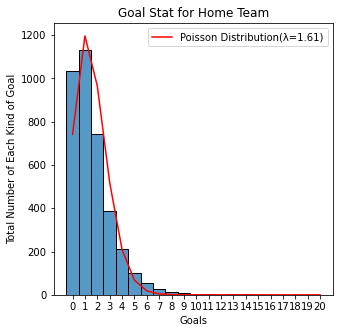

In [15]:
plt.figure(figsize=(5, 5))

x = list(range(0, score_upperbound + 1, 1))
y = list(acr_df['home_score'])

sns.histplot(data=y, discrete=True)
plt.xticks(x)
plt.xticks(np.arange(0, score_upperbound + 1, 1))
plt.title('Goal Stat for Home Team')
plt.ylabel('Total Number of Each Kind of Goal')
plt.xlabel('Goals')

lambda_home = acr_df['home_score'].mean()
plt.plot(np.arange(score_upperbound + 1), poisson.pmf(np.arange(0, score_upperbound + 1, 1), lambda_home)*acr_df.shape[0], label="Poisson Distribution(λ={:.2f})".format(lambda_home), color="red")

plt.legend()
plt.show()

# From the histogram, we can get some observations:


### 1. The data in the **beginning** of the histogram is **high** and for the**following part** is **low**.
### 2. The data is **positive-valued**, since they are index of goals;
### 3. The data is **continuous**.

The diagram match the Poisson Distribution.

<br />
<div style="font-size: 120%;">  
$$X \sim \text{Pois}(\lambda) $$
</div>

<img src="image/Poisson Distribution function.jpg" width=400 />

### Poisson Distribution:

<img src="image/poisson-distribution-figure.png" width=400 />

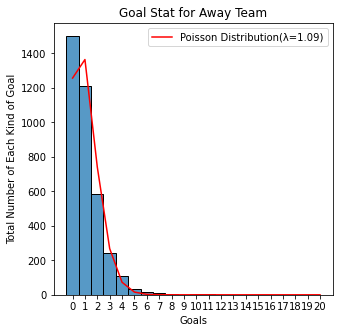

In [16]:
plt.figure(figsize=(5, 5))

x = list(range(0, score_upperbound + 1, 1))
y = list(acr_df['away_score'])

sns.histplot(data=y, discrete=True)
plt.xticks(x)
plt.title('Goal Stat for Away Team')
plt.ylabel('Total Number of Each Kind of Goal')
plt.xlabel('Goals')

lambda_away = acr_df['away_score'].mean()
plt.plot(np.arange(score_upperbound + 1), poisson.pmf(np.arange(0, score_upperbound + 1, 1), lambda_away)*acr_df.shape[0], label="Poisson Distribution(λ={:.2f})".format(lambda_away), color="red")

plt.legend()
plt.show()

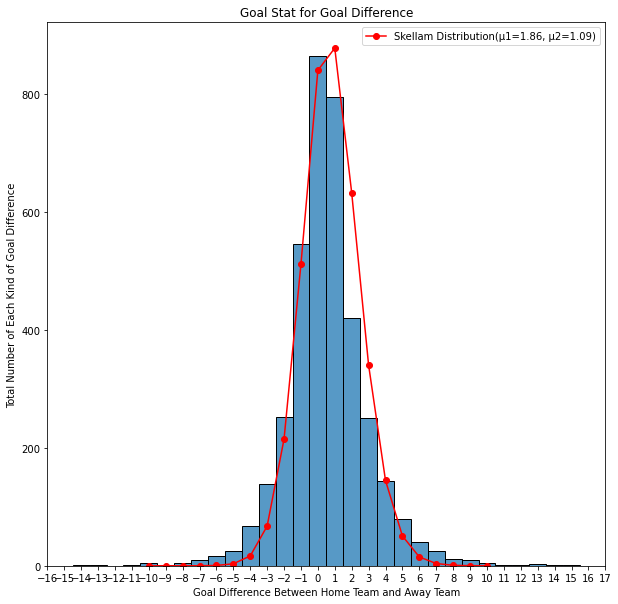

In [51]:
plt.figure(figsize=(10, 10))

x = list(range(score_upperbound * -1, score_upperbound + 1, 1))
y = list(acr_df['home_score'] - acr_df['away_score'])

sns.histplot(data=y, discrete=True)
plt.xticks(x)
plt.xticks(np.arange(score_upperbound * -1, score_upperbound + 1, 1))
plt.title('Goal Stat for Goal Difference')
plt.ylabel('Total Number of Each Kind of Goal Difference')
plt.xlabel('Goal Difference Between Home Team and Away Team')

plt.plot(np.arange(score_upperbound/2 * -1, score_upperbound/2 + 1), skellam.pmf(np.arange(score_upperbound/2 * -1, score_upperbound/2 + 1, 1), lambda_home, lambda_away)*acr_df.shape[0], '-o', label="Skellam Distribution(μ1={:.2f}, μ2={:.2f})".format(lambda_home, lambda_away), color="red")

plt.legend()
plt.show()

## From the histogram, we can get some observations:

1. The data is almost ***left-right symmetry***;
2. The data in the ***middle*** of the histogram is ***high*** and on ***both sides*** are ***low***.
3. The data is ***positive-valued***, since they are all index of goals;
4. The data is ***continuous***.

The diagram match the Skellam distribution.

<br />
<div style="font-size: 120%;">  

</div>

<img src="image/Skellam Distribution Figure.svg" width=400 />

### Skellam Distribution:

<img src="image/Skellam_distribution.svg.png" width=400 />


In [52]:
df = pd.read_csv('data/archive/results.csv')
grouped = df.groupby('tournament')
world_cup_df = grouped.get_group('FIFA World Cup')
number_of_goals = world_cup_df.home_score + world_cup_df.away_score
number_of_goals = number_of_goals[number_of_goals <= 10]
# number_of_goals

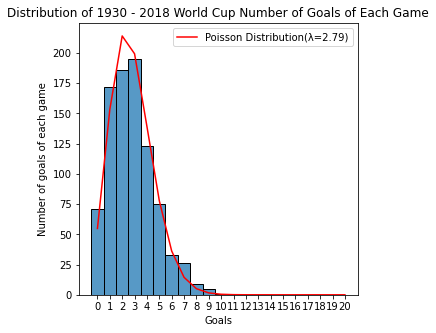

In [19]:
plt.figure(figsize=(5, 5))
score_upperbound = 20
x = list(range(0, score_upperbound + 1, 1))

sns.histplot(data=number_of_goals, discrete=True)
plt.xticks(x)
plt.xticks(np.arange(0, score_upperbound + 1, 1))
plt.title('Distribution of 1930 - 2018 World Cup Number of Goals of Each Game')
plt.ylabel('Number of goals of each game')
plt.xlabel('Goals')

lambda_world_cup_number_of_goals = number_of_goals.mean()
plt.plot(np.arange(score_upperbound + 1), poisson.pmf(np.arange(0, score_upperbound + 1, 1), lambda_world_cup_number_of_goals)*number_of_goals.shape[0], label="Poisson Distribution(λ={:.2f})".format(lambda_world_cup_number_of_goals), color="red")

plt.legend()
plt.show()

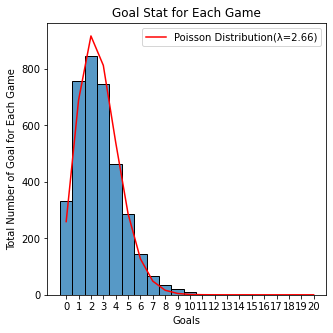

In [20]:
plt.figure(figsize=(5, 5))

x = list(range(0, score_upperbound + 1, 1))
y = acr_df.home_score + acr_df.away_score
y = y[y<11]

sns.histplot(data=y, discrete=True)
plt.xticks(x)
plt.title('Goal Stat for Each Game')
plt.ylabel('Total Number of Goal for Each Game')
plt.xlabel('Goals')

lambda_total = y.mean()
plt.plot(np.arange(score_upperbound + 1), poisson.pmf(np.arange(0, score_upperbound + 1, 1), lambda_total)*y.shape[0], label="Poisson Distribution(λ={:.2f})".format(lambda_total), color="red")

plt.legend()
plt.show()

In [21]:
def parse_worldcup_host(file_path="data/worldcupdata.txt"):
    data = list()
    with open(file_path, mode='r', encoding='utf-8') as f:
        skip_start_line = 3
        for line in islice(f, skip_start_line, None):
            fields = line.strip().split('\t')
            data.append(fields)

    return data

In [22]:
acr_record_worldcup_host = parse_worldcup_host()


acr_record_field_name = ['date', 'home_team', 'away_team', 'home_score', 'away_score', 'tournament', 'city', 'country', 'neutral', 'winner']

acr_df_worldcup_host = pd.DataFrame(acr_record_worldcup_host, columns =acr_record_field_name)
acr_df_worldcup_host['home_score'] = acr_df_worldcup_host['home_score'].astype(int)
acr_df_worldcup_host['away_score'] = acr_df_worldcup_host['away_score'].astype(int)
print(acr_df_worldcup_host)

          date home_team      away_team  home_score  away_score  \
0    1930/7/27   Uruguay     Yugoslavia           6           1   
1    1930/7/30   Uruguay      Argentina           4           2   
2    1934/5/27     Italy  United States           7           1   
3    1934/5/31     Italy          Spain           1           1   
4     1934/6/1     Italy          Spain           1           0   
..         ...       ...            ...         ...         ...   
111  2018/6/14    Russia   Saudi Arabia           5           0   
112  2018/6/19    Russia          Egypt           3           1   
113  2018/6/25    Russia        Uruguay           0           3   
114   2018/7/1    Russia          Spain           1           1   
115   2018/7/7    Russia        Croatia           2           2   

         tournament              city  country neutral    winner  
0    FIFA World Cup        Montevideo  Uruguay   FALSE      Host  
1    FIFA World Cup        Montevideo  Uruguay   FALSE      H

In [23]:
score_upperbound_worldcup_host = 10
print(acr_df_worldcup_host[acr_df_worldcup_host['home_score'] < score_upperbound_worldcup_host])
print(acr_df_worldcup_host[acr_df_worldcup_host['away_score'] < score_upperbound_worldcup_host])

          date home_team      away_team  home_score  away_score  \
0    1930/7/27   Uruguay     Yugoslavia           6           1   
1    1930/7/30   Uruguay      Argentina           4           2   
2    1934/5/27     Italy  United States           7           1   
3    1934/5/31     Italy          Spain           1           1   
4     1934/6/1     Italy          Spain           1           0   
..         ...       ...            ...         ...         ...   
111  2018/6/14    Russia   Saudi Arabia           5           0   
112  2018/6/19    Russia          Egypt           3           1   
113  2018/6/25    Russia        Uruguay           0           3   
114   2018/7/1    Russia          Spain           1           1   
115   2018/7/7    Russia        Croatia           2           2   

         tournament              city  country neutral    winner  
0    FIFA World Cup        Montevideo  Uruguay   FALSE      Host  
1    FIFA World Cup        Montevideo  Uruguay   FALSE      H

In [24]:
acr_df_worldcup_host.describe()

,home_score,away_score
count,116.000000,116.000000
mean,1.862069,0.974138
std,1.559802,1.268078
min,0.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,1.000000
75%,2.000000,1.000000
max,7.000000,7.000000


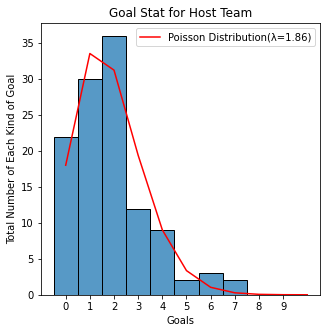

In [25]:
plt.figure(figsize=(5, 5))

x = list(range(0, score_upperbound_worldcup_host, 1))
y = list(acr_df_worldcup_host['home_score'])

sns.histplot(data=y, discrete=True)
plt.xticks(x)
plt.xticks(np.arange(0, score_upperbound_worldcup_host, 1))
plt.title('Goal Stat for Host Team')
plt.ylabel('Total Number of Each Kind of Goal')
plt.xlabel('Goals')

lambda_home = acr_df_worldcup_host['home_score'].mean()
plt.plot(np.arange(score_upperbound_worldcup_host + 1), poisson.pmf(np.arange(0, score_upperbound_worldcup_host + 1, 1), lambda_home)*acr_df_worldcup_host.shape[0], label="Poisson Distribution(λ={:.2f})".format(lambda_home), color="red")

plt.legend()
plt.show()

<AxesSubplot:xlabel='winner', ylabel='home_score'>

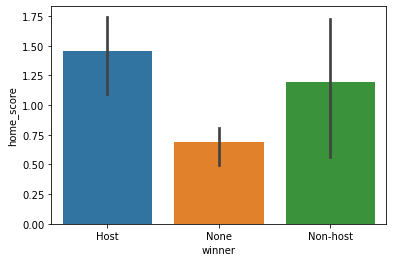

In [26]:
sns.barplot(x='winner',y='home_score',data=acr_df_worldcup_host,estimator=np.std)

# Part Two 

## Hypothesis

The result of game can be predicted by features within the game.

## Data Display

In [27]:
# import data from competition
# 133 fields
match_df = pd.read_csv('data/match.csv')
match_df.describe()

,id,country_id,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,...,home_team_cross,home_team_corner,home_team_possession,away_team_shoton,away_team_shotoff,away_team_foulcommit,away_team_card,away_team_cross,away_team_corner,away_team_possession
count,25979.000000,25979.000000,25979.000000,25979.000000,2.597900e+04,25979.000000,25979.000000,25979.000000,25979.000000,24158.000000,...,8465.000000,8464.000000,8419.000000,8463.000000,8463.000000,8465.000000,13773.000000,8465.000000,8464.000000,8419.000000
mean,12990.000000,11738.630317,11738.630317,18.242773,1.195429e+06,9984.371993,9984.475115,1.544594,1.160938,0.999586,...,18.870053,5.843809,51.796042,4.897436,4.994683,13.203544,2.433747,14.750030,4.523866,48.203958
std,7499.635658,7553.936759,7553.936759,10.407354,4.946279e+05,14087.453758,14087.445135,1.297158,1.142110,0.022284,...,8.195069,3.002254,9.401134,2.791269,2.619508,4.445138,1.463537,7.047327,2.594069,9.401134
min,1.000000,1.000000,1.000000,1.000000,4.831290e+05,1601.000000,1601.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,19.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.875000
25%,6495.500000,4769.000000,4769.000000,9.000000,7.684365e+05,8475.000000,8475.000000,1.000000,0.000000,1.000000,...,13.000000,4.000000,45.750000,3.000000,3.000000,10.000000,1.000000,10.000000,3.000000,42.000000
50%,12990.000000,10257.000000,10257.000000,18.000000,1.147511e+06,8697.000000,8697.000000,1.000000,1.000000,1.000000,...,18.000000,5.000000,52.000000,5.000000,5.000000,13.000000,2.000000,14.000000,4.000000,48.000000
75%,19484.500000,17642.000000,17642.000000,27.000000,1.709852e+06,9925.000000,9925.000000,2.000000,2.000000,1.000000,...,24.000000,8.000000,58.000000,7.000000,7.000000,16.000000,3.000000,19.000000,6.000000,54.250000
max,25979.000000,24558.000000,24558.000000,38.000000,2.216672e+06,274581.000000,274581.000000,10.000000,9.000000,2.000000,...,72.000000,20.000000,81.125000,19.000000,19.000000,32.000000,12.000000,59.000000,19.000000,80.500000


In [53]:
# Generate goal difference
goal_diff = match_df['home_team_goal'] - match_df['away_team_goal']

# Code result of competition
# host team wins：0
# draw：1
# away team wins：2
y = np.where(goal_diff > 0, 0, np.where(goal_diff < 0, 2, 1))

print('Prediction accuracy\n')
# Randomly guess
np.random.seed(42)
y_pred = np.random.choice([0,1,2], len(y))
print('Accuracy of randomly guess: {:.1f}%'.format(accuracy_score(y, y_pred)*100))

# Guess the probability that host team wins
y_pred = np.zeros(len(y))
print('Accuracy of predicting host team wins: {:.1f}%'.format(accuracy_score(y, y_pred)*100))

# Guess draw
y_pred = np.ones(len(y))
print('Accuracy of predicting draw: {:.1f}%'.format(accuracy_score(y, y_pred)*100))

# Guess the probability that the away team wins
y_pred = 2*np.ones(len(y))
print('Accuracy of predicting away team wins: {:.1f}%'.format(accuracy_score(y, y_pred)*100))

Prediction accuracy

Accuracy of randomly guess: 33.2%
Accuracy of predicting host team wins: 46.3%
Accuracy of predicting draw: 25.0%
Accuracy of predicting away team wins: 28.7%


In [54]:
# Data related to shot, like shot on, shot off and goal
shot_events = ['shoton', 'shotoff', 'goal']

home_team_feature = ['home_team_{}'.format(i) for i in shot_events]
away_team_feature = ['away_team_{}'.format(i) for i in shot_events]

# Remove NULL data
for col in home_team_feature + away_team_feature:
    match_df = match_df[match_df[col].notnull()]

# Generate number of shot
match_df['home_team_shot'] = match_df['home_team_shoton'] + match_df['home_team_shotoff'] + match_df['home_team_goal']
match_df['away_team_shot'] = match_df['away_team_shoton'] + match_df['away_team_shotoff'] + match_df['away_team_goal']

# Generate number of goal difference
goal_diff = match_df['home_team_goal'] - match_df['away_team_goal']

# Code result of competition
# host team wins：0
# draw：1
# away team wins：2
match_df['result'] = np.where(goal_diff > 0, 0, np.where(goal_diff < 0, 2, 1))

# Get features of a competition from data
events = ['foulcommit', 'card', 'cross', 'corner', 'possession', 'shot']
event_features = ['home_team_{}'.format(i) for i in events] + ['away_team_{}'.format(i) for i in events]

feature_list = event_features

# Geneate data set
match_sel = match_df
for col in feature_list:
    match_sel = match_sel[match_sel[col].notnull()]
    
# Divide dataset to train & test
train_df, test_df = train_test_split(match_sel, test_size=1000, random_state=42)

Xtrain = train_df[feature_list].values
Xtest = test_df[feature_list].values

y = match_sel['result'].values
ytrain = train_df['result'].values
ytest = test_df['result'].values

hgoaltrain = train_df['home_team_goal'].values
hgoaltest = test_df['home_team_goal'].values

agoaltrain = train_df['away_team_goal'].values
agoaltest = test_df['away_team_goal'].values

gdtrain = hgoaltrain-agoaltrain
gdtest = hgoaltest-agoaltest

# Data regulation
mms = MinMaxScaler()

Xtrain_norm = mms.fit_transform(Xtrain)
Xtest_norm = mms.transform(Xtest)

print('Total number in dataset: {}'.format(match_sel.shape[0]))
print('Train dataset(include cross validation data) : {}'.format(train_df.shape[0]))
print('Test dataset: {}'.format(test_df.shape[0]))

Total number in dataset: 8124
Train dataset(include cross validation data) : 7124
Test dataset: 1000


# Logistic Regression

The logistic model (or logit model) is a statistical model that models the probability of one event (out of two alternatives).

It is used to solve binary classification problems, to pridict classification, such as:
1. Win
2. Lose

## Logistic Regression = Linear Regression + Sigmoid Function
Linear Regression：

<img src="image/linear_regression.png" width="30%">

- A straight line fits the relationship between the ***independent*** variable and the ***dependent*** variable.
- Judging by the difference between the y-axis coordinates of the predicted point and the real point

## The expression for linear regression:
$$ f(x) = w^T*x + b $$

Linear regression gives a numerical value x for a calculated output y , so it is a model for solving a regression problem.

### Sigmoid Function：
<img src="image/sigmoid_function.svg" width="20%">

### Sigmoid Function image：	

#### 1. When input is close to negative infinity, the output is close to 0;
#### 2. When input is close to positive infinity, the output is close to 1;
#### 3. When input is equal to 0, the output is 0.5.

<img src="image/sigmoid_image.png" width="30%">

- The probability belongs to the interval [0,1]. 
- But the range for linear model $ f(x) = w^T*x + b $ is ($-\infty$,$+\infty$)

## The  Function of Logistic Regression
### Sigmoid Function will project the outcome of the linear function to a number between 0 and 1.

<img src="image/logistic_equation.svg" width="40%">

#### 1. Outcome < 0.5, the label will be 0;
#### 2. Outcome > 0.5, the label will be 1.
<img src="image/logistic_regression.png" width="60%">


## Loss Function
### The loss function is used to measure the difference between the output of the model and the real output.

- Suppose there are only two labels 1 and 0. 
- If we regard any set of samples collected as an event, then the probability of this event occurring is assumed to be p. 
- The value of our model y is equal to the probability that the label is 1 which is p.

Considering a single sample as an event, the probability of this event occurring is:

<img src="image/logistic_prob.svg" width="60%">

-  When y=1, the result is p;
-  When y=0, the result is 1-p.

- Function $ F(w) $ is also called its loss function. 

<img src="image/logisitic_loss.png" width="50%">
Meanwhile,
<img src="image/logisitic_loss2.svg" width="20%">

- The loss function can be understood as a function that measures the gap between the output of our current model and the actual output.
- The value of the loss function here is equal to the total probability of the event happening, and we want it to be as large as possible.

## Cross Validation
Divide raw data into groups：
1. The training set to train the model
2. The validation set to test model

the best C is 100000.0
The value of logarithmic loss (train set):  0.9327
The value of logarithmic loss (cross validation data)：0.9363


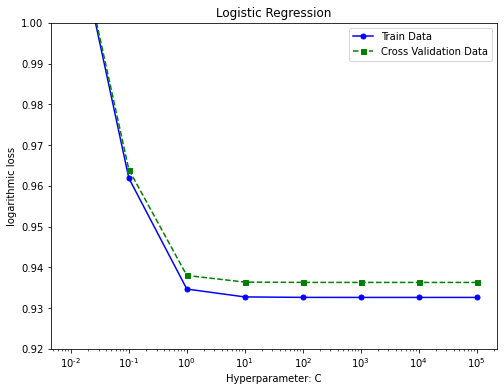

In [56]:
# Logistic Regression
clf = LogisticRegression(multi_class='auto', solver='liblinear')
parameter_dic= {'C':[0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5]}

# Determine hyperparameter by cross validation and logarithmic loss
cross_validation_fold = 5

train_scores, test_scores=validation_curve(estimator=clf,
                                           X=Xtrain_norm,
                                           y=ytrain,
                                           param_name=list(parameter_dic.keys())[0],
                                           param_range=parameter_dic.get(list(parameter_dic.keys())[0]),
                                           cv=cross_validation_fold, scoring='neg_log_loss')
train_mean=np.mean(train_scores, axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores, axis=1)
test_std=np.std(test_scores,axis=1)

clf_dict = {'LogisticRegression': 'Logistic Regression',
            'GradientBoostingClassifier': 'Gradient Boosting',
            'RandomForestClassifier': 'Random Forest'
           }
plt.figure(figsize=(8,6))
plt.rcParams['mathtext.fontset'] = 'cm'
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),-1*train_mean,
         color='blue',marker='o',
         markersize=5,label='Train Data')
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),-1*test_mean,
         color='green',linestyle='--',
         marker='s',markersize=5,label='Cross Validation Data')
plt.xlabel('Hyperparameter: {}'.format(list(parameter_dic.keys())[0]))
plt.ylabel('logarithmic loss')
plt.legend(loc='upper right')
plt.title('{}'.format(clf_dict[clf.__class__.__name__]))
if clf.__class__.__name__ == 'LogisticRegression':
    plt.xscale('log')
plt.ylim(0.92, 1)

print('the best {} is {}'.format(list(parameter_dic.keys())[0], parameter_dic.get(list(parameter_dic.keys())[0])[np.argmax(test_mean)]))
print('The value of logarithmic loss (train set):  {:.4f}'.format(-1*train_mean[np.argmax(test_mean)]))
print('The value of logarithmic loss (cross validation data)：{:.4f}'.format(-1*np.max(test_mean)))

In [57]:
best_clf = LogisticRegression(C=100000, multi_class='auto', solver='liblinear')

best_clf.fit(Xtrain_norm, ytrain)
ytest_prob = best_clf.predict_proba(Xtest_norm)

# Model assessment
print('Logistic regression model assessment')
print('Logarithmic loss: {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('Prediction accuracy: {:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

Logistic regression model assessment
Logarithmic loss: 0.9240
Prediction accuracy: 56.6%


## Linear discriminant analysis (LDA)

### Introduction

Linear discriminant analysis (LDA), normal discriminant analysis (NDA), or discriminant function analysis is a generalization of Fisher's linear discriminant, a method used in statistics and other fields, to find a linear combination of features that characterizes or separates two or more classes of objects or events. The resulting combination may be used as a linear classifier, or, more commonly, for dimensionality reduction before later classification.

The thought of LDA is: maximize mean between classes while minimizing variance with one specific class. It means that the data is projected in a low dimension. The projection points of the same type of data are as close as possible after projection, and the center points of the projection points of different types of data are as far away as possible.

<img src="image/LDA_eg_figure.png" width = "40%" height = "40%" alt="LDA_eg_figure.png" align=center />


### Mathematical Mechanism

Let's take a brief introduction about the mathematical mechanism behind LDA.

Taking the simplest two categories as an example, suppose that xi, ui, and Σi represent the set of sample points, mean vector, and covariance matrix of the i-th category, respectively. If the data is projected onto the straight line w, the centers of the two types of samples are on the straight line. The projections on are w^T * u1 and w^T * u2, respectively. After all sample points are projected onto the straight line, the covariances of the two types of samples are w^T * Σ1w and w^T * Σ2w, respectively. We want to make the distance between categories larger and the distance between categories smaller, that is, to maximize the formula (1). Here we define two more concepts, one is the within-class scatter matrix, which is the formula (2), and the other is the between-class scatter matrix, that is, the figure 2 in (3) formula. Then the problem of maximizing equation (1) is transformed into maximizing a Rayleigh entropy, that is, maximizing equation (4).

<img src="image/LDA_format_1.png" width = "50%" height = "50%" alt="LDA_format_1.png" align=center />

Solving Equation (4) is equivalent to solving Equation (5). Using Lagrangian multiplication to solve Equation (6), it is transformed into a problem of finding the characteristic equation, and It is to find the eigenvectors corresponding to the n-1 largest eigenvalues (n is the dimension). This can be done as we normally solve the characteristic equation.

<img src="image/LDA_format_2.png" width = "40%" height = "40%" alt="LDA_format_2.png" align=center />


### How to Use

It will be very troublesome to deduce according to the above principles, but scikit-learn has provided us with a out-of-the-box LDA API, we just need to call it in scikit-learn library directly.

In [32]:
# LDA model
best_clf = LinearDiscriminantAnalysis()

best_clf.fit(Xtrain_norm, ytrain)
ytest_prob = best_clf.predict_proba(Xtest_norm)

#### Model assessment
print('Linear classifier model assessment')
print('Logarithmic loss：{:.3f}'.format(log_loss(ytest, ytest_prob)))
print('Accuracy：{:.2f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

Linear classifier model assessment
Logarithmic loss：0.920
Accuracy：56.60%


## Poisson Regression

### Introduction

**Poisson regression** is a generalized linear model form of regression analysis used to model **count data**. Poisson regression assumes the response variable Y has a Poisson distribution, and assumes the logarithm of its expected value can be modeled by a linear combination of unknown parameters. It tells you which variables have a significant effect on the response variable (by poisson regression coefficient).

$log(E(Y|x)) = \alpha + \beta' x = \theta' x$,

θ is simply α concatenated to β.

when given a Poisson regression model θ and an input vector x, the predicted mean of the associated Poisson distribution is given by

$E(Y|x) = e^{\theta' x}$,

If Y are independent observations with corresponding values x of the predictor variables, then θ can be estimated by MLE.

**Poisson regression models** use logarithm as the link function, and Poisson distribution function as the assumed probability distribution of the response.

**Skellam distribution** is the discrete probability distribution of the difference N1-N2 of two statistically independent random variables N1 and N2 each Poisson-distributed with respective expected values $\mu1$ and $\mu2$.

Let k1 and k2 be two Poisson-distributed r.v. with expected values $\lambda1$ and $\lambda2$. Then, k1 - k2 follows a Skellam distribution with parameters $\mu1 = \lambda1 - \rho\sqrt{\lambda1 - \lambda2}$ and $\mu2 = \lambda2 - \rho\sqrt{\lambda1 - \lambda2}$, where $\rho$ is the correlation coefficient between k1 and k2. If the two Poisson-distributed r.v. are independent then $\rho = 0$. So in our case, $\mu1 = \lambda1$ and $\mu2 = \lambda2$.

In [33]:
class PoissonRegression:
    
    def __init__(self):
        pass
    
    def fit(self, X_home, X_away, hgoal, agoal):
        """
        fit poisson reg model for poisson ditribution
        """
        self.hgoal_reg = sm.GLM(hgoal, X_home, family=sm.families.Poisson()).fit()
        self.agoal_reg = sm.GLM(agoal, X_away, family=sm.families.Poisson()).fit()
        
    def _lambda(self, X_home, X_away):
        """
        Estimated goals for home team and away team
        """
        
        hgoal_lambda = self.hgoal_reg.predict(X_home)
        agoal_lambda = self.agoal_reg.predict(X_away)
        
        return hgoal_lambda, agoal_lambda

    def predict_proba(self, X_home, X_away, n_max=20):
        """
        Predict match outcome probabilities
        """
        
        hgoal_lambda, agoal_lambda = self._lambda(X_home, X_away)
        
        hgoal_mu1 = hgoal_lambda.reshape(-1,1)
        agoal_mu2 = agoal_lambda.reshape(-1,1)

        p_win = np.sum(skellam.pmf(np.arange(n_max)+1, hgoal_mu1, agoal_mu2), axis=1)
        p_draw = np.sum(skellam.pmf(0, hgoal_mu1, agoal_mu2), axis=1)
        p_lose = np.sum(skellam.pmf(np.arange(n_max)-n_max, hgoal_mu1, agoal_mu2), axis=1)
    
        p_matrix = np.array([p_win, p_draw, p_lose]).transpose()
        
        return p_matrix
    
    def predict(self, X_home, X_away, n_max=20):
        """
        Predict match outcomes.
        """

        ypred = self.predict_proba(X_home, X_away, n_max=n_max).argmax(axis=1)
        
        return ypred

In [34]:
best_clf = PoissonRegression()

best_clf.fit(Xtrain_norm, Xtrain_norm, hgoaltrain, agoaltrain)
ytest_prob = best_clf.predict_proba(Xtest_norm, Xtest_norm)

#### model estimation
print('log loss：{:.4f}'.format(log_loss(ytest, ytest_prob)))
print('prediction accuracy：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

log loss：0.9329
prediction accuracy：56.0%


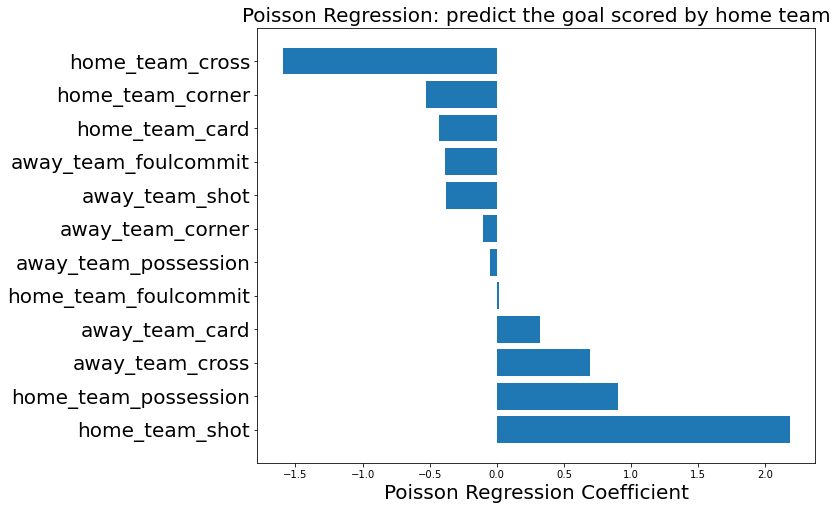

In [35]:
feature_name = ['home_team_foulcommit', 'home_team_card', 'home_team_cross', 'home_team_corner', 'home_team_possession', 'home_team_shot', 'away_team_foulcommit', 'away_team_card', 'away_team_cross', 'away_team_corner', 'away_team_possession', 'away_team_shot']

importance_list, name_list = zip(*sorted(zip(best_clf.hgoal_reg.params, feature_name),reverse=True))

plt.figure(figsize=(10,8))
plt.barh(range(len(name_list)), importance_list,align='center')
plt.yticks(range(len(name_list)), name_list, fontsize=20)
plt.xlabel('Poisson Regression Coefficient', fontsize=20)
plt.title('Poisson Regression: predict the goal scored by home team', fontsize=20)
plt.show()

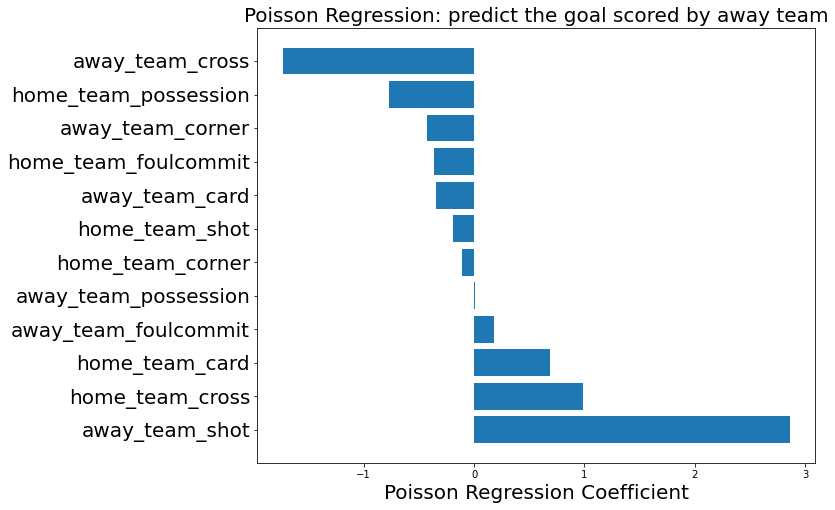

In [36]:
importance_list, name_list = zip(*sorted(zip(best_clf.agoal_reg.params, feature_name),reverse=True))

plt.figure(figsize=(10,8))
plt.barh(range(len(name_list)), importance_list,align='center')
plt.yticks(range(len(name_list)), name_list, fontsize=20)
plt.xlabel('Poisson Regression Coefficient', fontsize=20)
plt.title('Poisson Regression: predict the goal scored by away team', fontsize=20)
plt.show()

# The core idea of XGBoost algorithm:
1. Gradient boosting algorithm based on CART regression tree.
2. Multiple rounds of iteration, each iteration generates a weak classifier, and each classifier is trained on the basis of the gradient of the previous round of classifiers.
3. Let the loss function continue to decline, that is, the model is constantly being transformed.


<img src="image/XGBoost_Algorithm.png" width="50%">

# Advantages of XGBoost algorithm:
The loss function of the XGBoost algorithm, in addition to its own loss, also adds a regularization part to prevent overfitting.
<img src="image/XGBoost_1.png" width="50%">

# The tree building process of XGBoost (Greedy algorithm):
Starting from a tree with a depth of 0, for all possible features of each leaf node
1. Find the best split point for each feature and record the maximum profit;
2. Select the feature that benefits the most as the split feature and generate nodes;

Judging Criteria: Information Gain

Assuming that a node is split into two nodes, left and right LR, the objective function before splitting is:
<img src="image/before_split.png" width="20%">

After splitting it is:
<img src="image/after_split.png" width="20%">

The information gain is:
<img src="image/information_gain.png" width="40%">

## Basic Modeling Process
   - According to the result of the previous weak estimator $f(x)_{k-1}$, calculate the loss function L.
   - And use L to influence the construction of the next weak estimator $f(x)_k$.
   - The final output is affected by all weak evaluators $f(x)_0-f(x)_k$.

# Three elements of XGBoost:
   1. Loss function $L(y,\hat y)$:  It is used to measure the difference between the predicted results of the model and the real results.
   2. Weak Evaluator $f(x)$:  Decision Tree.
   3. Comprehensive integration result $H(x)$:  How the integration algorithm specifically outputs the integration result.


# XGBoost parameters

Before running the XGBoost program, three types of parameters must be set: general parameters, booster parameters, and task parameters.
1. General parameters: 
* The parameter determines which booster is used in the promotion process. 
* Common boosters include tree model and linear model.

2. Booster parameter: 
* The setting of this parameter depends on which booster model we choose.

3. Learning task parameters task parameters: 
* The setting of the parameters determines which learning scenario.
* For example, the regression task will use different parameters to control the sorting task

In [59]:
param_reg = {} 
param_reg['objective'] = 'reg:linear'
param_reg['eval_metric'] =  'rmse'
param_reg['booster'] = 'gbtree'
param_reg['silent'] = 1

param_reg['eta'] = 0.07
param_reg['subsample'] = 0.4
param_reg['colsample_bytree'] = 0.9
param_reg['max_depth'] = 2
param_reg['num_parallel_tree'] = 4
param_reg['min_child_weight'] = 5

parameter_dic = {'eta':np.arange(0.01, 0.1, 0.01)}
param_tune = list(parameter_dic.keys())[0]
param_len = len(parameter_dic[param_tune])

cross_validation_fold = 10

xgb_cv = []
kf = KFold(n_splits=cross_validation_fold, shuffle=True, random_state=42)

train_mean = []
val_mean = []

reg_progress = {}
clf_progress = {}

reg_num_boost_round_mean = []
clf_num_boost_round_mean = []

for i in range(param_len):
    param_reg[param_tune] = parameter_dic[param_tune][i]
    
    train_scores = []
    val_scores = []
    
    reg_num_boost_round = []
    clf_num_boost_round = []
    
    for train, val in kf.split(Xtrain, gdtrain):
        dtrain = xgb.DMatrix(Xtrain[train], label = gdtrain[train])
        dval = xgb.DMatrix(Xtrain[val], label = gdtrain[val])
        reg = xgb.train(params=param_reg, dtrain=dtrain,
                        num_boost_round=3000,
                        early_stopping_rounds=25, evals=[(dval,'validation')],
                        evals_result=reg_progress,
                        verbose_eval=False)
        reg_num_boost_round.append(len(reg_progress['validation']['rmse']))
        Ztrain = reg.predict(dtrain).reshape(-1, 1)
        Zval = reg.predict(dval).reshape(-1, 1)
        ltrain = xgb.DMatrix(Ztrain, label=ytrain[train])
        lval = xgb.DMatrix(Zval, label = ytrain[val])
        
        clf = LogisticRegression(solver='liblinear', C=10000) # minimizing regularization by setting C to a very large number
        clf.fit(Ztrain, ytrain[train])
        train_scores.append(log_loss(ytrain[train], clf.predict_proba(Ztrain)))
        val_scores.append(log_loss(ytrain[val], clf.predict_proba(Zval)))

    train_mean.append(np.mean(np.array(train_scores)))
    val_mean.append(np.mean(np.array(val_scores)))
    
    reg_num_boost_round_mean.append(np.mean(np.array(reg_num_boost_round)))

print(reg_num_boost_round_mean)

[20:52:23] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:52:23] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:52:35] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:52:35] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:52:46] WARNING: ../src/objective/regression_

[20:54:45] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:45] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:54:49] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:49] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:54:53] WARNING: ../src/objective/regression_

[20:55:36] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:55:36] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:55:37] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:55:37] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:55:40] WARNING: ../src/objective/regression_

[20:56:09] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:56:09] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:56:11] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:56:11] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:56:13] WARNING: ../src/objective/regression_

[20:56:37] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:56:37] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:56:39] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:56:39] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:56:41] WARNING: ../src/objective/regression_

[1481.7, 771.2, 516.1, 434.5, 330.5, 297.7, 273.5, 240.7, 204.0]


Best eta: 0.08
Logarithmic loss(cross validation data): 0.9436


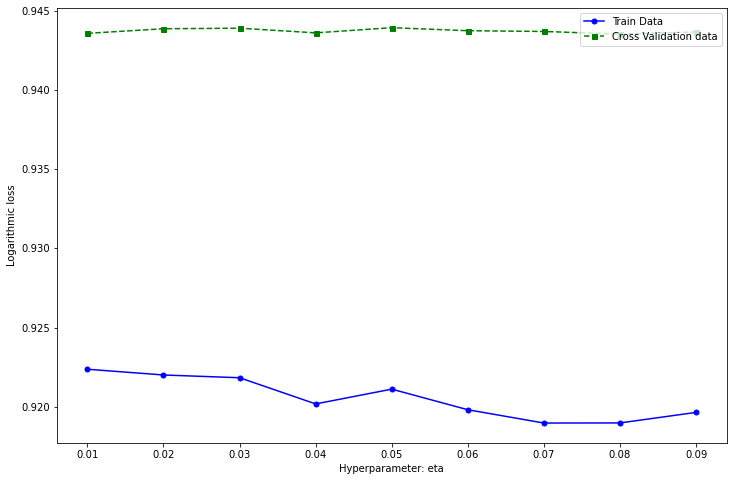

In [60]:
plt.figure(figsize=(12, 8))
plt.plot(parameter_dic[param_tune], np.array(train_mean),
         color='blue', marker='o', markersize=5, label='Train Data')
plt.plot(parameter_dic[param_tune], np.array(val_mean),
         color='green', linestyle='--', marker='s', markersize=5, label='Cross Validation data')
plt.xlabel('Hyperparameter: {}'.format(param_tune))
plt.ylabel('Logarithmic loss')
plt.legend(loc='upper right')
print('Best {}: {}'.format(param_tune, parameter_dic[param_tune][np.argmin(val_mean)]))
print('Logarithmic loss(cross validation data): {:.4f}'.format(np.min(val_mean)))

In [61]:
param_reg = {} 
param_reg['objective'] = 'reg:linear'
param_reg['eval_metric'] =  'rmse'
param_reg['booster'] = 'gbtree'
param_reg['silent'] = 1

param_reg['eta'] = 0.07
param_reg['subsample'] = 0.4
param_reg['colsample_bytree'] = 0.9
param_reg['max_depth'] = 2
param_reg['num_parallel_tree'] = 4
param_reg['min_child_weight'] = 5

dtrain = xgb.DMatrix(Xtrain, label = gdtrain)
reg = xgb.train(params=param_reg, dtrain=dtrain,
                num_boost_round=int(263),
                verbose_eval=False)
        
Ztrain = reg.predict(dtrain).reshape(-1, 1)
clf = LogisticRegression(solver='liblinear', C=10000)
clf.fit(Ztrain, ytrain)

dtest = xgb.DMatrix(Xtest, label = gdtest)
Ztest = reg.predict(dtest).reshape(-1,1)
ytest_prob = clf.predict_proba(Ztest)

print('XGBoost Model Assessment')
print('Logarithmic loss: {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('Prediction accuracy: {:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

[20:57:03] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:57:03] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBoost Model Assessment
Logarithmic loss: 0.9274
Prediction accuracy: 56.7%


## Random Forest

### intro

**Random forest** combines the output of multiple decision trees (each tree should have low correlation with other trees) to reach a single result. Random forest algorithm is based on ensemble learning, where you join different types of algorithms or same algorithm multiple times to form a more powerful prediction model. 

Ensures low correlation between different decision trees:
+ **bagging**: randomly sample from the dataset with replacement
+ **feature randomness**: each tree in a random forest can pick only from a random subset of features

So in random forest, trees are not only trained on different sets of data but also use different features to make decisions.

regression: averaged
classifier: a majority vote

Benefits:
+ Reduced risk of overfitting
+ Provides flexibility
+ Easy to determine feature importance

> The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.


<img src="https://1.cms.s81c.com/sites/default/files/2020-12-07/Random%20Forest%20Diagram.jpg" width="400" height="400" />

### Cross validation:

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. It helps to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting. 

So we use k-fold cross validation to prevent overfitting.


In [40]:
clf = RandomForestClassifier(max_features=3, n_estimators=160)
parameter_dic= {'n_estimators':range(10, 200, 10)}

# use crossvalidation and log loss to determine the n-estimator
# default cross_validation_fold in sklearn is 5
cross_validation_fold = 5

train_scores, test_scores=validation_curve(estimator=clf,
                                           X=Xtrain,
                                           y=ytrain,
                                           param_name='n_estimators',
                                           param_range=parameter_dic.get('n_estimators'),
                                           cv=cross_validation_fold,
                                           scoring='neg_log_loss')
train_mean=np.mean(train_scores, axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores, axis=1)
test_std=np.std(test_scores,axis=1)

Text(0.5, 1.0, 'RandomForestClassifier')

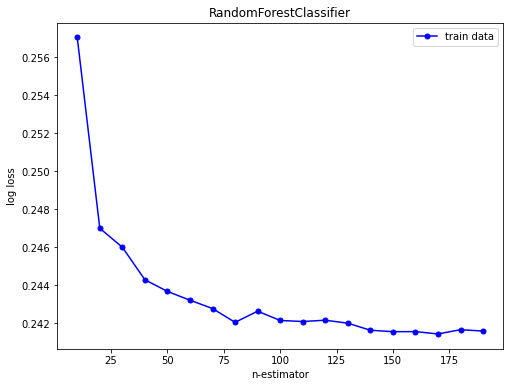

In [41]:
plt.figure(figsize=(8,6))
plt.plot(parameter_dic.get('n_estimators'),-1*train_mean,
         color='blue',marker='o',
         markersize=5,label='train data')
plt.xlabel('n-estimator')
plt.ylabel('log loss')
plt.legend(loc='upper right')
plt.title('RandomForestClassifier')

the best n-estimator is:180
log loss（train data): 0.2416
log loss (cross validation data): 0.9577


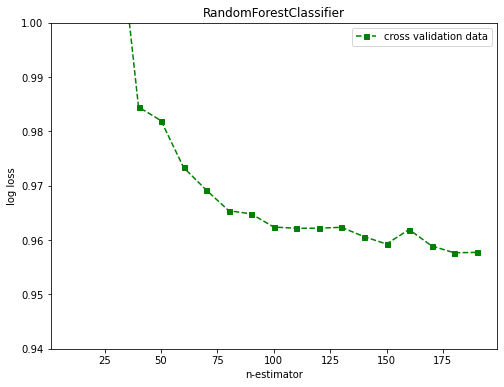

In [42]:
plt.figure(figsize=(8,6))
plt.plot(parameter_dic.get('n_estimators'),-1*test_mean,
         color='green',linestyle='--',
         marker='s',markersize=5,label='cross validation data')
plt.xlabel('n-estimator')
plt.ylabel('log loss')
plt.legend(loc='upper right')
plt.title('RandomForestClassifier')
plt.ylim(0.94, 1)

index_of_max = np.argmax(test_mean)
best_n_estimator = parameter_dic.get('n_estimators')[index_of_max]
print('the best n-estimator is:{}'.format(best_n_estimator))
print('log loss（train data): {:.4f}'.format(-1*train_mean[index_of_max]))
print('log loss (cross validation data): {:.4f}'.format(-1*np.max(test_mean)))

In [43]:
best_clf = RandomForestClassifier(max_features=3, n_estimators=best_n_estimator)

np.random.seed(42)
best_clf.fit(Xtrain, ytrain)
ytest_prob = best_clf.predict_proba(Xtest)

#### model estimation
print('log loss：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('prediction accuracy：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

log loss：  0.9459
prediction accuracy：56.5%


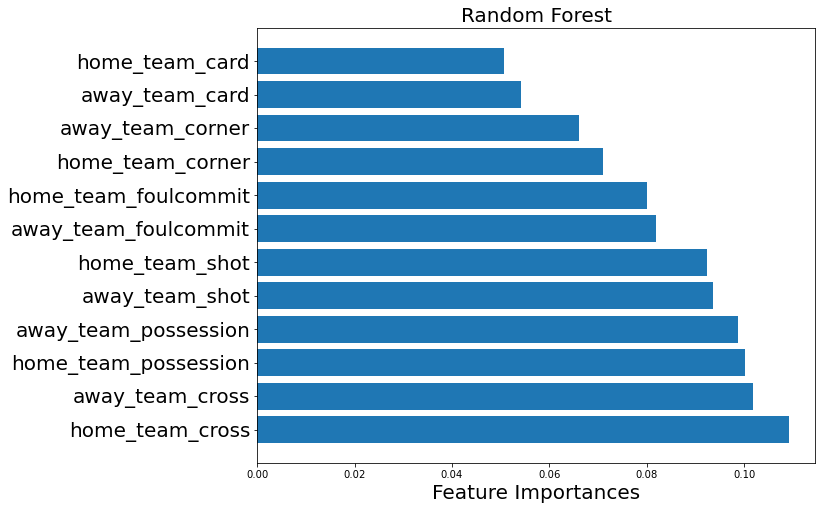

In [44]:
importance_list = best_clf.feature_importances_
feature_name = ['home_team_foulcommit', 'home_team_card', 'home_team_cross', 'home_team_corner', 'home_team_possession', 'home_team_shot', 'away_team_foulcommit', 'away_team_card', 'away_team_cross', 'away_team_corner', 'away_team_possession', 'away_team_shot']
importance_list, name_list = zip(*sorted(zip(importance_list, feature_name),reverse=True))
plt.figure(figsize=(10,8))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list, fontsize=20)
plt.xlabel('Feature Importances', fontsize=20)
plt.title('Random Forest', fontsize=20)
plt.show()


## Neural Network

### What is Neural Network?

A neural network is a network or circuit of biological neurons, or, in a modern sense, an artificial neural network, composed of artificial neurons or nodes. Thus, a neural network is either a biological neural network, made up of biological neurons, or an artificial neural network, used for solving artificial intelligence (AI) problems. The connections of the biological neuron are modeled in artificial neural networks as weights between nodes. A positive weight reflects an excitatory connection, while negative values mean inhibitory connections. All inputs are modified by a weight and summed. This activity is referred to as a linear combination. Finally, an activation function controls the amplitude of the output. For example, an acceptable range of output is usually between 0 and 1, or it could be −1 and 1.


### Components of a Neural Network

#### Neurons

A neuron takes inputs, does some math with them, and produces one output.

Like, y = f(x1 * w1 + x2 * w2 + b)

####  Activation Function

The activation function is used to turn an unbounded input into an output that has a nice, predictable form.
Some commonly used activation function are sigmoid function, and relu function.

The sigmoid function only outputs numbers in the range (0,1). You can think of it as compressing (−∞,+∞) to (0,1) — big negative numbers become ~0, and big positive numbers become ~1.

The relu function is piecewise linear function, it maps all negative values to 0, and keep positive values unchanged.

We apply relu activation function on our model, because it has the following advantages: 
For linear functions, relu is more expressive, especially in deep networks; 
For nonlinear functions, relu doesn't have the problem of Gradient Disappearance because the gradient of the non-negative interval is constant (Vanishing Gradient Problem, which usually exists when using sigmoid function), so that the convergence rate of the model is maintained in a stable state.

#### Layer

A neural network is nothing more than a bunch of neurons connected together. From the floor plan of the network, we can divide it into several layers. Basically there are 3 kinds of layers, namely input layer, output layer, and hidden layer. A hidden layer is any layer between the input (first) layer and output (last) layer. FOr a neural network, it may have multiple hidden layers.

<img src="image/nn_layer_figure.png" width = "50%" height = "50%" alt="nn_layer_figure.png" align=center />

####  Feed Forward (Forward Propagation)

The process of passing inputs forward to get an output is known as Feed Forward, or Forward Propagation.

Let’s use the picture above and assume all neurons have the same weights w=\[0, 1\], the same bias b=0, and the same sigmoid activation function. Let h1, h2, o1 denote the outputs of the neurons they represent. What happens if we pass in the input x=\[2, 3\]?

h1 = h2 = f(w * x + b) = f((0 * 2) + (1 * 3) + 0) =  f(3) = relu(3) = 3
o1 = f(w * h + b) = f((0 * h1 + 1 * h2) + b) = f(3) = relu(3) = 3

That's how Forward Propagation works.

#### Back Propagation & Optimization Algorithm & Gradient Descent

In machine learning, back propagation is a widely used algorithm for training feedforward neural networks.
The backpropagation algorithm works by computing the gradient of the loss function with respect to each weight by the chain rule, computing the gradient one layer at a time, iterating backward from the last layer to avoid redundant calculations of intermediate terms in the chain rule.

In this program, we use Adam optimization to adjust weights of model.

#### Loss

Before training our neural network, we need to define a way how the network measures prediction efficiency, and we call it "Loss Value", and our model tries to minimize loss value in order to get better accuracy. 

In this program, program computes the cross-entropy loss between true labels and predicted labels.



In [45]:
def plot_history(history, kind):
    plt.figure()
    plt.xlabel('Iteration Round')
    if kind == 'accuracy':
        plt.ylabel('Accuracy')
        plt.plot(history.epoch, np.array(history.history['accuracy']),
                 label='Training Set')
        plt.plot(history.epoch, np.array(history.history['val_accuracy']),
                 label = 'Validation Set')
        plt.legend()
    elif kind == 'loss':
        plt.ylabel('Logarithmic Loss')
        plt.plot(history.epoch, np.array(history.history['loss']),
                 label='Training Set')
        plt.plot(history.epoch, np.array(history.history['val_loss']),
                 label = 'Validation Set')
        plt.legend()
        
    plt.show()


In [46]:
# Divide train set, and validation set
train_x, val_x, train_y, val_y = train_test_split(Xtrain_norm, ytrain, test_size=1000, stratify=ytrain, random_state=42)

def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu,
                          input_shape=(Xtrain_norm.shape[1],), ),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(3, activation=tf.nn.softmax)
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.optimizers.Adam(),
                  metrics=['accuracy'])
    
    return model

model = build_model()

2022-05-03 20:13:03.612942: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-03 20:13:03.615595: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


In [47]:
history = model.fit(train_x, train_y, epochs=500,
                    validation_data=(val_x, val_y), verbose=0)

In [48]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Accuracy upon train set is 56.42%
Logarithmic loss upon train set is 0.923
Accuracy upon validation set is  56.40%
Logarithmic loss upon validation set is 0.938


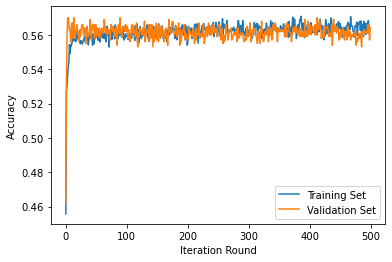

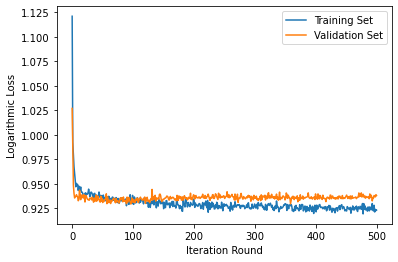

In [49]:
print('Accuracy upon train set is {:.2f}%'.format(history.history['accuracy'][-1]*100))
print('Logarithmic loss upon train set is {:.3f}'.format(history.history['loss'][-1]))

print('Accuracy upon validation set is  {:.2f}%'.format(history.history['val_accuracy'][-1]*100))
print('Logarithmic loss upon validation set is {:.3f}'.format(history.history['val_loss'][-1]))

plot_history(history, kind='accuracy')
plot_history(history, kind='loss')
# plt.ylim(0.9, 1);

In [50]:
# Fitting data
model.fit(Xtrain_norm, ytrain, epochs=500, verbose=0)

# Output prediction probability of test set
ytest_prob = model.predict_proba(Xtest_norm)

# Model assessment
print('Model assignment for neural network model')
print('Logarithmic Loss: {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('Accuracy: {:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

Model assignment for nn model
Logarithmic Loss: 0.9227
Accuracy: 56.0%


## Part2 Overview

In part2, six different statistical and machine learning models are adopted to predict the result of a soccer game upon a data set about European football competitions.

Each model and its prediction accuracy on test set are represented as following:

| Model Name        | accuracy |
| --------   | -----:  |
| Logistic Regression | 56.6% |
| Linear discriminant analysis | 56.60% |
| Poisson Regression | 56.0% |
| XGBoost | 56.7% |
| Random Forest | 56.5% |
| Neural Network | 56.0% |

XGBoost model can predict 56.7% record correctly which is the best performance among these model.